In [62]:
import tensorflow as tf
import matplotlib.pyplot as plt
import xarray as xr
import fnmatch
import numpy as np
import os
import pandas as pd
from surgeNN.io import load_predictand,load_predictors
from surgeNN.preprocessing import get_denseloss_weights,get_splitted_predictand_and_predictor_data,stack_predictors_for_lstm, normalize_predictand_splits, normalize_predictor_splits,standardize_predictand_splits, standardize_predictor_splits
from surgeNN.models import build_LSTM_stacked
from surgeNN.models import build_LSTM_stacked
from surgeNN.losses import gevl,mse_exp_negexp
from surgeNN.utils import create_batched_sequenced_datasets, compute_statistics_for_output_ds, generate_windowed_finite_numpy_input,rmse
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from target_relevance import TargetRelevance #if starting with a clean environment, first, in terminal, do->'mamba install kdepy'

import gc #callback to clean up garbage after each epoch, not sure if needed (usage: callbacks = [GC_Callback()])
class GC_Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

Configure the script:

In [305]:
tgs        = ['barcelona-bar-esp-cmems.csv','den_helder-denhdr-nld-rws.csv', 'brest-822a-fra-uhslc.csv', 
            'immingham-imm-gbr-bodc.csv','stavanger-svg-nor-nhs.csv'] #tide gauges to process
tg = 'den_helder-denhdr-nld-rws.csv'
temp_freq = 6 # [hours] temporal frequency to use
n_cells   = 5 #n x n grid cells around tide gauge of predictor data to use

var_names = ['msl','u10','v10','w'] #variables to use
loss_function = 'mse_exp' # any default loss function or 'DenseLoss_[default loss function]' or 'gevl'
alpha = 5 #DenseLoss alpha parameter, vary between 1-5? (not used if not using loss function)
gamma = 3 #gevl gamma parameter, vary between 1-3? (not used if not using loss function)
a = .5
t = 1

input_dir  = '/home/jovyan/test_surge_models/input/' #directory with predictor & predictand data
output_dir = '/home/jovyan/test_surge_models/results/lstm_loss_function_tests/' #where to store the results

n_runs = 1 #how many iterations with different hyperparameter combinations to run
n_epochs = 75 #how many training epochs
patience = 5 #early stopping patience
split_fractions = [.5,.25,.25] #train, test, val

#hyperparameters:
batch_size = np.array([128]).astype('int')
n_steps = np.array([5]).astype('int') #at and 12h or 24h or 36h before (to-do: also use timesteps after?)
n_lstm = np.array([2]).astype('int')
n_lstm_units = np.array([48]).astype('int')
n_dense = np.array([2]).astype('int')
n_dense_units = np.array([48]).astype('int')
dropout = np.array([0.1])
lrs = np.array([1e-5])
l1s = np.array([0.02])

possible_params = [batch_size, n_steps, n_lstm, n_lstm_units,
                    n_dense, n_dense_units, dropout, lrs, l1s]

n_combinations = np.prod(np.array([len(k) for k in possible_params])) #number of unique combinations possible

Determine loss function to use:

In [306]:

predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_anoms_deseasoned_predictands',tg) #open predictand csv
predictand = predictand.set_index('date').resample(str(temp_freq)+'h').fillna(method=None) #insert nans where timesteps are missing
predictand = predictand.reset_index()[['surge','date','lon','lat']]

predictand['surge'] = predictand['surge'].rolling(window=int(12/temp_freq+1),min_periods=int(12/temp_freq+1),center=True).mean() #crude way to filter out peaks due to uncorrected tides (Tiggeloven et al., 2021)


In [307]:
predictand.groupby(predictand.date.dt.month).surge.max()

date
1     1.904412
2     1.567064
3     1.528587
4     1.266428
5     0.645139
6     0.818463
7     0.755332
8     0.879114
9     1.149075
10    1.445626
11    1.500942
12    1.641191
Name: surge, dtype: float64

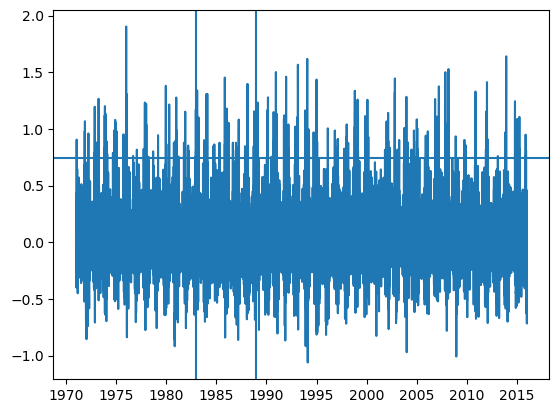

In [308]:
plt.plot(predictand['date'],predictand['surge'])
#plt.axhline(y=np.nanpercentile(predictand['surge'],99.7))
#plt.axhline(y=np.nanpercentile(predictand['surge'],99))
plt.axvline(x=predictand['date'][int(len(predictand['date'].iloc[0:35062])*.5)])
plt.axvline(x=predictand['date'][int(len(predictand['date'].iloc[0:35062])*.75)])

dmax = predictand.groupby(pd.Grouper(key='date',freq='D')).surge.max()
plt.axhline(y=np.nanpercentile(dmax,98))


In [113]:

ymax_sorted = ymax.sort_values(ascending=False)
ymax_sorted = ymax_sorted[0:27]

In [125]:
ymax_bins = [ymax_sorted[k:k+4] for k in np.arange(0,len(ymax_sorted),4)]


In [128]:
random_bin_idx = [np.random.choice(np.arange(4), size=len(b), replace=False) for b in ymax_bins]

In [169]:
#retrieve years to select for each split
list_of_years = [[ymax_bins[k].index.values[np.where((random_bin_idx[k]==i))[0]][0] for k in np.arange(len(random_bin_idx)) if i in random_bin_idx[k]] for i in np.arange(4)]

In [178]:
len_order = np.argsort([len(k) for k in list_of_years])

In [195]:
np.sort(np.hstack([np.array(list_of_years[k]) for k in len_order[0:2]]))

array([1993, 1996, 1997, 2000, 2004, 2007, 2009, 2010, 2011, 2013, 2016,
       2017, 2018], dtype=int32)

[[1992, 1985, 1987, 2010, 1999, 1981, 1995, 1996, 1984], [2007, 1994, 2011, 1989, 1980, 2004, 1971, 2008, 2009], [1993, 2002, 1982, 2003, 1977, 2001, 1997, 1978, 1976], [1975, 1991, 1979, 1983, 2014, 1973, 1974, 2005, 1970], [2013, 1990, 2006, 1998, 1972, 1988, 1986, 2015, 2012, 2000]]


/tmp/ipykernel_1079/899771342.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictand_a['date'] = predictand_a['date'] + td
/tmp/ipykernel_1079/899771342.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictand_b['date'] = predictand_b['date'] + td
/tmp/ipykernel_1079/899771342.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

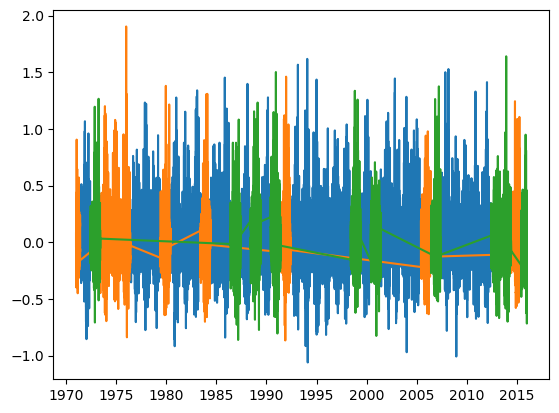

In [309]:
predictand_shifted = predictand.copy(deep=True)
#throw out last 2 days of june to be able to use predictors with lead time up to 8 timesteps
predictand=predictand[[not ((m == 6) & (d>28)) for m,d in zip(predictand.date.dt.month,predictand.date.dt.day)]]

td = np.timedelta64('183','D')#start in july



#on shifted or not????

predictand_shifted['date'] = predictand['date'] - td

#np.random.seed(1)


def split_stratified_amax(predictand,split_fractions):
    
    #to-do implement something that automatically works out appropriate bins for custom split_fractions and takes into account missing values in the timeseries...
    if split_fractions == [0.5,0.25,0.25]:
        l_bins = 4
    elif split_fractions == [0.6,0.2,0.2]:
        l_bins = 5
    else:
        raise Exception('split fraction not yet implemented')
        
    standardized_amax = predictand.groupby(predictand.date.dt.year).surge.max()/np.nanstd(predictand['surge'],ddof=0)
    amax_sorted = standardized_amax.sort_values(ascending=False)
    amax_bins = [amax_sorted[k:k+l_bins] for k in np.arange(0,len(amax_sorted),l_bins)] #bin sorted amax to divide over splits
    
    split_idx = [np.random.choice(np.arange(l_bins), size=len(this_bin), replace=False) for this_bin in amax_bins]
    
    #retrieve years to select for each split
    split_years = [[amax_bins[bin_idx].index.values[np.where((split_idx[bin_idx]==i))[0]][0] for bin_idx in np.arange(len(split_idx)) if i in split_idx[bin_idx]] for i in np.arange(l_bins)]
    
    #sort according to ascending length:
    length_sorted_idx = np.argsort([len(k) for k in split_years])
    print(split_years)
    years_a = np.sort(np.hstack([np.array(split_years[k]) for k in length_sorted_idx[0:int(l_bins*split_fractions[0])]]))
    years_b = np.sort(np.array(split_years[length_sorted_idx[-2]]))
    years_c = np.sort(np.array(split_years[length_sorted_idx[-1]]))
    
    return years_a, years_b, years_c

years_a, years_b, years_c = randomly_split_years_with_stratified_amax(predictand_shifted,[.6,.2,.2])

predictand_a = predictand_shifted[[k in years_a for k in predictand_shifted.date.dt.year]]
predictand_b = predictand_shifted[[k in years_b for k in predictand_shifted.date.dt.year]]
predictand_c = predictand_shifted[[k in years_c for k in predictand_shifted.date.dt.year]]

predictand_a['date'] = predictand_a['date'] + td
predictand_b['date'] = predictand_b['date'] + td
predictand_c['date'] = predictand_c['date'] + td

plt.plot(predictand_a['date'],predictand_a['surge'])
plt.plot(predictand_b['date'],predictand_b['surge'])
plt.plot(predictand_c['date'],predictand_c['surge'])

#probably need to mask out first n days in each year? otherwise would use predictors for one split at same days of predictands at other splits

In [351]:
predictand['date']-np.timedelta64('184','D')#start in july


0       1970-07-01 00:00:00
1       1970-07-01 06:00:00
2       1970-07-01 12:00:00
3       1970-07-01 18:00:00
4       1970-07-02 00:00:00
                ...        
65739   2015-06-29 18:00:00
65740   2015-06-30 00:00:00
65741   2015-06-30 06:00:00
65742   2015-06-30 12:00:00
65743   2015-06-30 18:00:00
Name: date, Length: 65744, dtype: datetime64[ns]

In [350]:
predictand['date']

0       1971-01-01 00:00:00
1       1971-01-01 06:00:00
2       1971-01-01 12:00:00
3       1971-01-01 18:00:00
4       1971-01-02 00:00:00
                ...        
65739   2015-12-30 18:00:00
65740   2015-12-31 00:00:00
65741   2015-12-31 06:00:00
65742   2015-12-31 12:00:00
65743   2015-12-31 18:00:00
Name: date, Length: 65744, dtype: datetime64[ns]

In [346]:
predictand_shifted=predictand_shifted[[not ((m == 6) & (d>28)) for m,d in zip(predictand_shifted.date.dt.month,predictand_shifted.date.dt.day)]]

In [347]:
predictand_shifted

,surge,date,lon,lat
0,NaN,1971-01-01 00:00:00,4.74499,52.964357
1,-0.032791,1971-01-01 06:00:00,4.74499,52.964357
2,0.066267,1971-01-01 12:00:00,4.74499,52.964357
3,0.086608,1971-01-01 18:00:00,4.74499,52.964357
4,0.043554,1971-01-02 00:00:00,4.74499,52.964357
...,...,...,...,...
65739,-0.697692,2015-12-30 18:00:00,4.74499,52.964357
65740,-0.414111,2015-12-31 00:00:00,4.74499,52.964357
65741,0.088533,2015-12-31 06:00:00,4.74499,52.964357
65742,0.377569,2015-12-31 12:00:00,4.74499,52.964357


In [337]:
predictand

,surge,date,lon,lat
0,NaN,1971-01-01 00:00:00,4.74499,52.964357
1,-0.032791,1971-01-01 06:00:00,4.74499,52.964357
2,0.066267,1971-01-01 12:00:00,4.74499,52.964357
3,0.086608,1971-01-01 18:00:00,4.74499,52.964357
4,0.043554,1971-01-02 00:00:00,4.74499,52.964357
...,...,...,...,...
65739,-0.697692,2015-12-30 18:00:00,4.74499,52.964357
65740,-0.414111,2015-12-31 00:00:00,4.74499,52.964357
65741,0.088533,2015-12-31 06:00:00,4.74499,52.964357
65742,0.377569,2015-12-31 12:00:00,4.74499,52.964357


In [339]:
2*8*45

720

In [334]:
[((m == 6) & (d>28)) for m,d in zip(predictand_shifted.date.dt.month,predictand_shifted.date.dt.day)]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,


In [326]:
360/12

30.0

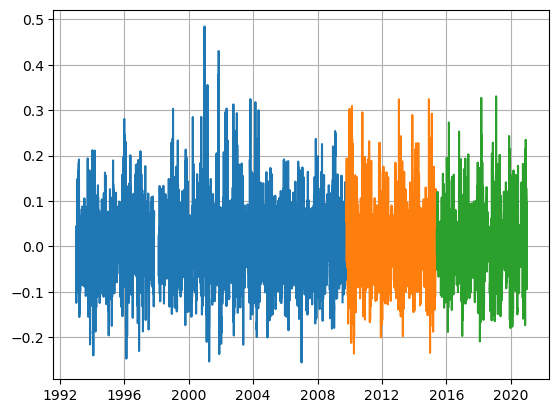

In [294]:
plt.plot(predictand['date'][0:int(len(predictand['surge'])*.6)],predictand['surge'][0:int(len(predictand['surge'])*.6)])
plt.plot(predictand['date'][int(len(predictand['surge'])*.6):int(len(predictand['surge'])*.8)],predictand['surge'][int(len(predictand['surge'])*.6):int(len(predictand['surge'])*.8)])
plt.plot(predictand['date'][int(len(predictand['surge'])*.8):int(len(predictand['surge'])*1)],predictand['surge'][int(len(predictand['surge'])*.8):int(len(predictand['surge'])*1)])
plt.grid()


In [299]:
predictand.sort_values(ascending=False,by='surge')[0:20]

,surge,date,lon,lat
11658,0.484356,2000-12-24 18:00:00,2.163,41.341999
11659,0.469537,2000-12-25 00:00:00,2.163,41.341999
11660,0.455024,2000-12-25 06:00:00,2.163,41.341999
11657,0.433927,2000-12-24 12:00:00,2.163,41.341999
12945,0.430376,2001-11-11 12:00:00,2.163,41.341999
12944,0.424201,2001-11-11 06:00:00,2.163,41.341999
11665,0.416497,2000-12-26 12:00:00,2.163,41.341999
11669,0.410922,2000-12-27 12:00:00,2.163,41.341999
11667,0.409541,2000-12-27 00:00:00,2.163,41.341999
11666,0.408991,2000-12-26 18:00:00,2.163,41.341999


In [226]:
a,b,c=randomly_split_years_with_stratified_amax(predictand,[.6,.2,.2])

In [230]:
years_c

array([1993, 1995, 1998, 2004, 2019], dtype=int32)

In [59]:
np.sum((dmax>np.nanpercentile(dmax,98)).values)

1

In [56]:
dmax>np.nanpercentile(dmax,98)

date
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24     True
25    False
26    False
27    False
28    False
29    False
30    False
31    False
Name: surge, dtype: bool

In [20]:
len(np.arange(1993,2018))*.35

12.5

In [21]:
1993+12.5

2005.5

In [ ]:
1993+12.5

In [147]:
ds = xr.open_mfdataset(os.path.join(output_dir,'exp_t_tests')+'/*barc*',concat_dim='t',combine='nested').load()

In [109]:
ds = xr.open_mfdataset(os.path.join(output_dir,'dl_alpha_tests')+'/*bres*',concat_dim='a',combine='nested').load()

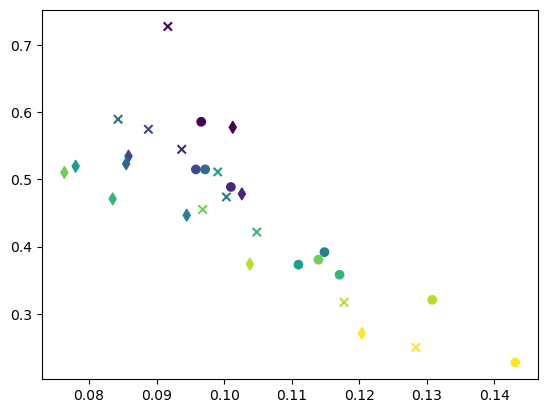

In [53]:
plt.figure()
#plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=0),ds.sel(split='val').isel(i=0).f1.isel(quantile=0))
plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=1),ds.sel(split='val').isel(i=0).recall.isel(quantile=1),c=ds.t)
plt.scatter(ds.sel(split='test').isel(i=0).rmse_extremes.isel(quantile=1),ds.sel(split='test').isel(i=0).recall.isel(quantile=1),c=ds.t,marker='x')
plt.scatter(ds.sel(split='train').isel(i=0).rmse_extremes.isel(quantile=1),ds.sel(split='train').isel(i=0).recall.isel(quantile=1),c=ds.t,marker='d')
#plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=2),ds.sel(split='val').isel(i=0).f1.isel(quantile=2))

In [93]:
ds.rmse_extremes.sel(split='test')

<xarray.DataArray 'rmse_extremes' (a: 14, i: 1, quantile: 3)>
array([[[0.07136795, 0.08076752, 0.09270959]],

       [[0.06432326, 0.08125784, 0.09793722]],

       [[0.05845046, 0.06873844, 0.08199826]],

       [[0.0592304 , 0.07327605, 0.08950432]],

       [[0.0568306 , 0.0704561 , 0.08666029]],

       [[0.05624873, 0.06358179, 0.07472736]],

       [[0.0563737 , 0.06647309, 0.08094225]],

       [[0.05671048, 0.06112627, 0.07275989]],

       [[0.06005457, 0.06106795, 0.07160456]],

       [[0.06020973, 0.0601023 , 0.07084299]],

       [[0.06143625, 0.0637784 , 0.0766447 ]],

       [[0.06527902, 0.05941804, 0.06173204]],

       [[0.06660683, 0.05997408, 0.06889078]],

       [[0.07047875, 0.06106987, 0.06390647]]])
Coordinates:
    split     <U4 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: a, i

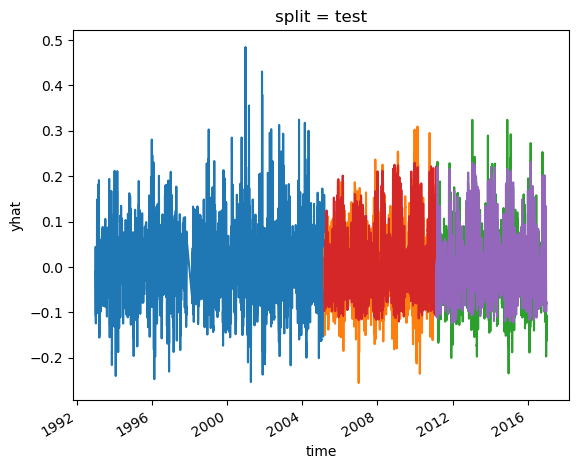

In [171]:

ds.o.isel(i=0,t=1).sel(split='train').plot()
ds.o.isel(i=0,t=1).sel(split='val').plot()
ds.o.isel(i=0,t=1).sel(split='test').plot()
ds.yhat.isel(i=0,t=1).sel(split='val').plot()
ds.yhat.isel(i=0,t=1).sel(split='test').plot()


array([[1.        , 0.43832139],
       [0.43832139, 1.        ]])

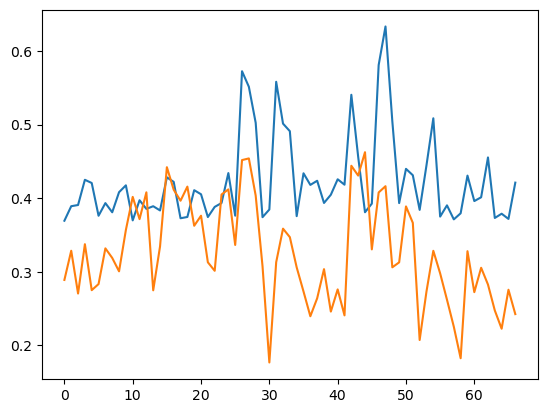

In [117]:
plt.figure()
plt.plot(ds.o.sel(split='test').isel(i=0,t=4).where(ds.o.sel(split='test').isel(i=0,t=4)>ds.o.sel(split='test').isel(i=0,t=4).quantile(.995,dim='time'),drop=True).values)
plt.plot(ds.yhat.sel(split='test').isel(i=0,t=4).where(ds.o.sel(split='test').isel(i=0,t=4)>ds.o.sel(split='test').isel(i=0,t=4).quantile(.995,dim='time'),drop=True).values)

np.corrcoef(ds.yhat.sel(split='test').isel(i=0,t=2).where(ds.o.sel(split='test').isel(i=0,t=2)>ds.o.sel(split='test').isel(i=0,t=2).quantile(.99,dim='time'),drop=True).values,ds.o.sel(split='test').isel(i=0,t=2).where(ds.o.sel(split='test').isel(i=0,t=2)>ds.o.sel(split='test').isel(i=0,t=2).quantile(.99,dim='time'),drop=True).values)


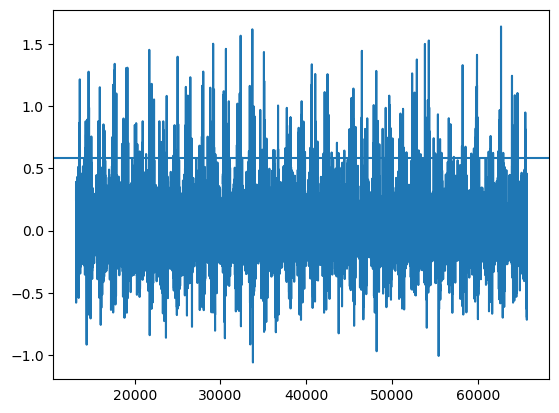

In [127]:
predictand.surge.plot()
plt.axhline(y=np.nanpercentile(predictand.surge,98))

In [164]:
predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_anoms_deseasoned_predictands','barcelona-bar-esp-cmems.csv')
predictand['ht'] = predictand['surge']>np.nanpercentile(predictand['surge'],99)
predictand.groupby(predictand.date.dt.year).ht.sum()



date
1993     0
1994     6
1995     8
1996    12
1997     2
1998     3
1999    14
2000    41
2001    25
2002    35
2003    12
2004    22
2005     1
2006     1
2007     7
2008     8
2009    28
2010    36
2011    15
2012     0
2013    18
2014    26
2015    13
2016    11
2017     4
2018    26
2019    17
2020    10
Name: ht, dtype: int64

In [172]:
np.nanpercentile(predictand['surge'],99)

0.20876030122126818

In [169]:
(6+8+12+2+3+14+41+25+35+12+22)/11

16.363636363636363

In [167]:
(1+1+7+8+28+36)/5

16.2

In [168]:
ds.time[np.isfinite(ds.o.sel(split='train').isel(i=0,t=0))]

<xarray.DataArray 'time' (time: 17106)>
array(['1993-01-02T12:00:00.000000000', '1993-01-02T18:00:00.000000000',
       '1993-01-03T00:00:00.000000000', ..., '2005-03-08T06:00:00.000000000',
       '2005-03-08T12:00:00.000000000', '2005-03-08T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1993-01-02T12:00:00 ... 2005-03-08T18:00:00
    split    <U5 'train'

In [165]:
ds.time[np.isfinite(ds.o.sel(split='test').isel(i=0,t=0))]

<xarray.DataArray 'time' (time: 8551)>
array(['2011-02-23T06:00:00.000000000', '2011-02-23T12:00:00.000000000',
       '2011-02-23T18:00:00.000000000', ..., '2016-12-31T00:00:00.000000000',
       '2016-12-31T06:00:00.000000000', '2016-12-31T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2011-02-23T06:00:00 ... 2016-12-31T12:00:00
    split    <U4 'test'

In [161]:
np.isfinite(ds.o.sel(split='val').isel(i=0))

<xarray.DataArray 'o' (t: 10, time: 34208)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-02T12:00:00 ... 2016-12-31T12:00:00
    split    <U3 'val'
Dimensions without coordinates: t

In [125]:
np.nanpercentile(predictand.surge,98)

0.5813708848702184

0.06889077951864037

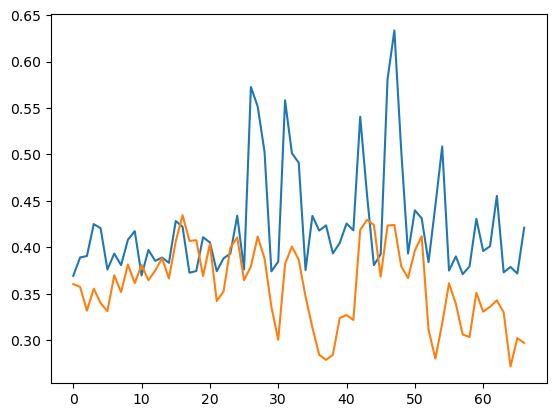

In [112]:
plt.figure()
plt.plot(ds.o.sel(split='test').isel(i=0,a=-2).where(ds.o.sel(split='test').isel(i=0,a=-2)>ds.o.sel(split='test').isel(i=0,a=-2).quantile(.995,dim='time'),drop=True).values)
plt.plot(ds.yhat.sel(split='test').isel(i=0,a=-2).where(ds.o.sel(split='test').isel(i=0,a=-2)>ds.o.sel(split='test').isel(i=0,a=-2).quantile(.995,dim='time'),drop=True).values)

rmse(ds.yhat.sel(split='test').isel(i=0,a=-2).where(ds.o.sel(split='test').isel(i=0,a=-2)>ds.o.sel(split='test').isel(i=0,a=-2).quantile(.99,dim='time'),drop=True).values,ds.o.sel(split='test').isel(i=0,a=-2).where(ds.o.sel(split='test').isel(i=0,a=-2)>ds.o.sel(split='test').isel(i=0,a=-2).quantile(.99,dim='time'),drop=True).values)


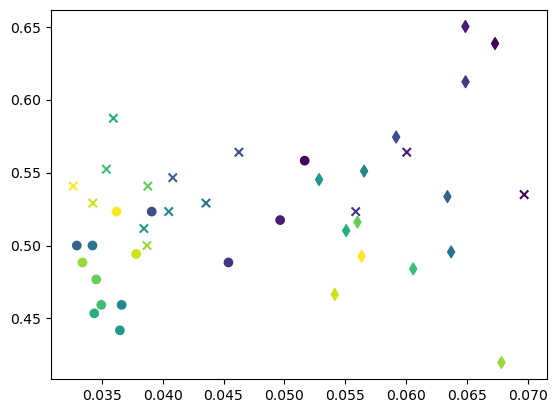

In [63]:
qnts = [.95,.98,.99]
tp_self = (((ds.o>=ds.o.quantile(qnts,dim='time'))) & (ds.yhat>=ds.yhat.quantile(qnts,dim='time'))).where(np.isfinite(ds.o)).sum(dim='time')
fp_self = (((ds.o>=ds.o.quantile(qnts,dim='time'))==False) & (ds.yhat>=ds.yhat.quantile(qnts,dim='time'))).where(np.isfinite(ds.o)).sum(dim='time')
precision_self = tp_self/(tp_self+fp_self)
plt.figure()
#plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=0),ds.sel(split='val').isel(i=0).f1.isel(quantile=0))
plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=1),precision_self.sel(split='val').isel(i=0).isel(quantile=1),c=ds.alpha)
plt.scatter(ds.sel(split='test').isel(i=0).rmse_extremes.isel(quantile=1),precision_self.sel(split='test').isel(i=0).isel(quantile=1),c=ds.alpha,marker='x')
plt.scatter(ds.sel(split='train').isel(i=0).rmse_extremes.isel(quantile=1),precision_self.sel(split='train').isel(i=0).isel(quantile=1),c=ds.alpha,marker='d')
#plt.scatter(ds.sel(split='val').isel(i=0).rmse_extremes.isel(quantile=2),ds.sel(split='val').isel(i=0).f1.isel(quantile=2))

In [47]:
precision_self

<xarray.DataArray (alpha: 14, i: 1, split: 3, quantile: 3)>
array([[[[0.73841555, 0.6953271 , 0.7238806 ],
         [0.65321375, 0.58208955, 0.57462687],
         [0.65171898, 0.57089552, 0.56716418]]],


       [[[0.71524664, 0.68598131, 0.70522388],
         [0.62182362, 0.56716418, 0.54477612],
         [0.6651719 , 0.59701493, 0.51492537]]],


       [[[0.7122571 , 0.69345794, 0.72761194],
         [0.61733931, 0.57835821, 0.58208955],
         [0.65919283, 0.57462687, 0.52985075]]],


       [[[0.70702541, 0.72336449, 0.78358209],
         [0.59790732, 0.54104478, 0.50746269],
         [0.64723468, 0.5858209 , 0.48507463]]],


...


       [[[0.62331839, 0.6411215 , 0.66791045],
         [0.60239163, 0.52238806, 0.55970149],
         [0.61434978, 0.55970149, 0.50746269]]],


       [[[0.61958146, 0.60560748, 0.6641791 ],
         [0.60089686, 0.55223881, 0.53731343],
         [0.63976084, 0.60074627, 0.54477612]]],


       [[[0.60014948, 0.58691589, 0.62313433],
         [0.59940209, 0.50746269, 0.58208955],
         [0.6083707 , 0.52238806, 0.48507463]]],


       [[[0.61883408, 0.55514019, 0.52238806],
         [0.58594918, 0.5261194 , 0.52238806],
         [0.61136024, 0.54477612, 0.5       ]]]])
Coordinates:
  * split     (split) object 'train' 'val' 'test'
  * alpha     (alpha) float64 1.0 1.5 2.0 2.5 3.0 3.5 ... 5.5 6.0 6.5 7.0 7.5
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: i

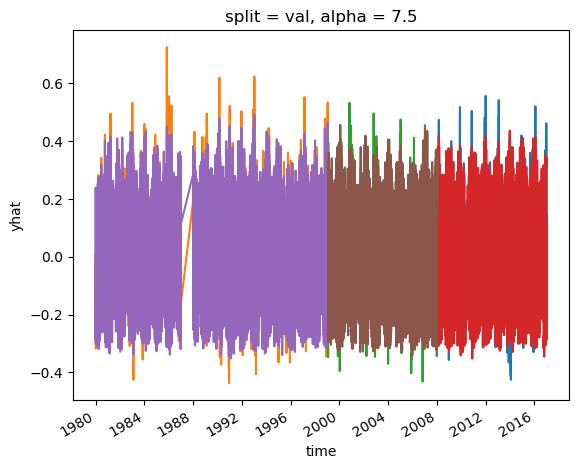

In [43]:
ds.o.isel(alpha=-1,i=0).sel(split='test').plot()
ds.o.isel(alpha=-1,i=0).sel(split='train').plot()
ds.o.isel(alpha=-1,i=0).sel(split='val').plot()
ds.yhat.isel(alpha=-1,i=0).sel(split='test').plot()
ds.yhat.isel(alpha=-1,i=0).sel(split='train').plot()
ds.yhat.isel(alpha=-1,i=0).sel(split='val').plot()

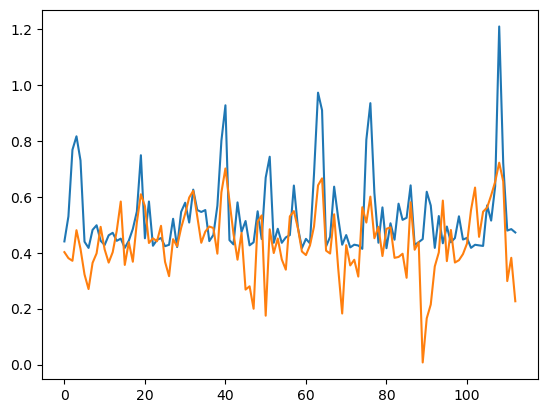

In [56]:
plt.figure()
plt.plot(ds.o.sel(split='test').isel(alpha=-6).isel(i=0).where(ds.o.sel(split='test').isel(alpha=-4).isel(i=0)>ds.o.sel(split='test').isel(alpha=-4).isel(i=0).quantile(.99,dim='time'),drop=True).values)
plt.plot(ds.yhat.sel(split='test').isel(alpha=-6).isel(i=0).where(ds.o.sel(split='test').isel(alpha=-4).isel(i=0)>ds.o.sel(split='test').isel(alpha=-4).isel(i=0).quantile(.99,dim='time'),drop=True).values)


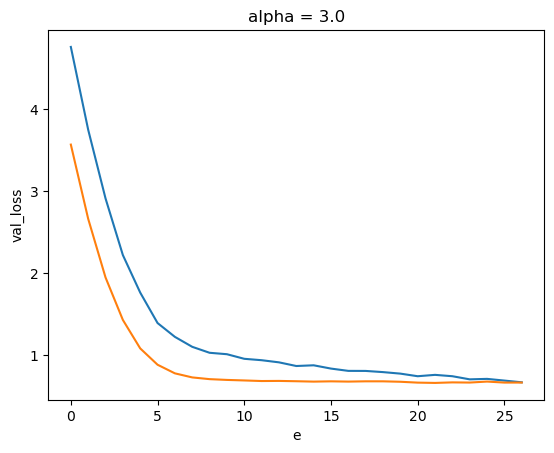

In [19]:
ds.loss.sel(alpha=3).isel(i=0).plot()
ds.val_loss.sel(alpha=3).isel(i=0).plot()

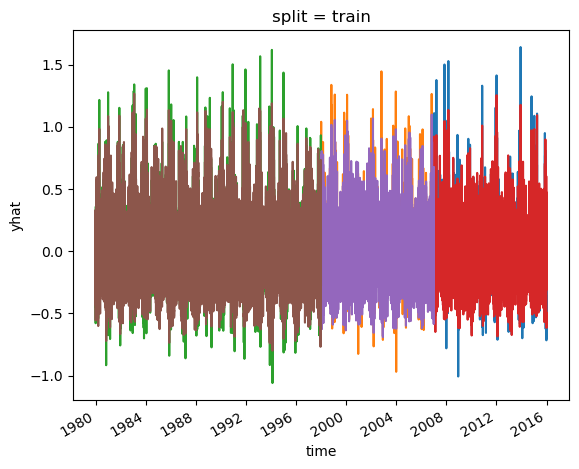

In [7]:
out_ds.o.sel(split='test').plot()
out_ds.o.sel(split='val').plot()
out_ds.o.sel(split='train').plot()

out_ds.yhat.sel(split='test').plot()
out_ds.yhat.sel(split='val').plot()
out_ds.yhat.sel(split='train').plot()

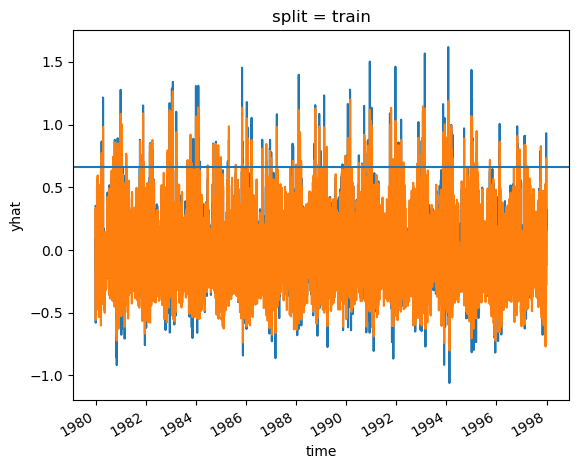

In [8]:
plt.figure()
#out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

#out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='train').isel(i=0).plot()
out_ds.yhat.sel(split='train').isel(i=0).plot()
plt.axhline(y=out_ds.yhat.sel(split='train').isel(i=0).quantile(.98,dim='time').values)

(-2.0, 2.0)

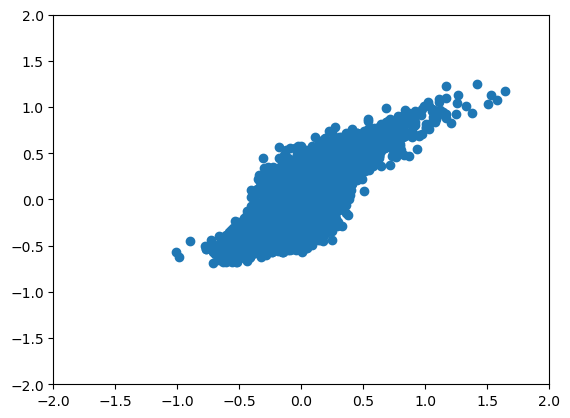

In [9]:
plt.scatter(out_ds.o.sel(split='test').isel(i=0),out_ds.yhat.sel(split='test').isel(i=0))
plt.ylim([-2,2])
plt.xlim([-2,2])

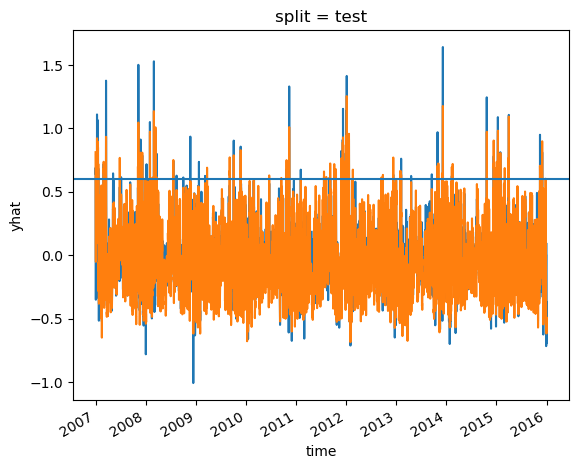

In [ ]:
plt.figure()
#out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

#out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
#out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='test').isel(i=0).plot()
out_ds.yhat.sel(split='test').isel(i=0).plot()
plt.axhline(y=out_ds.yhat.sel(split='test').isel(i=0).quantile(.98,dim='time').values)

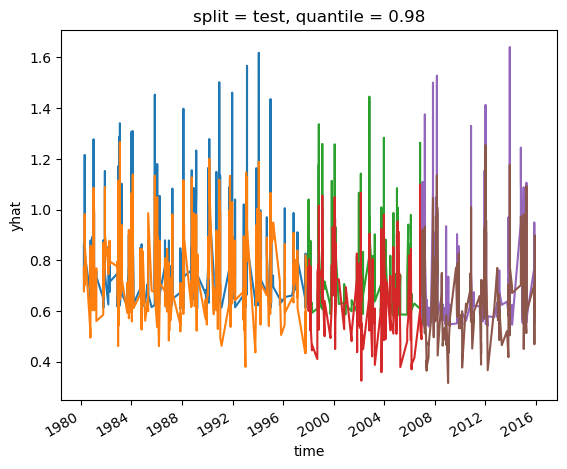

In [ ]:
plt.figure()
out_ds.o.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='train').isel(i=0).where(out_ds.o.sel(split='train').isel(i=0)>out_ds.o.sel(split='train').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='val').isel(i=0).where(out_ds.o.sel(split='val').isel(i=0)>out_ds.o.sel(split='val').isel(i=0).quantile(.98,dim='time'),drop=True).plot()

out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).plot()
out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).plot()


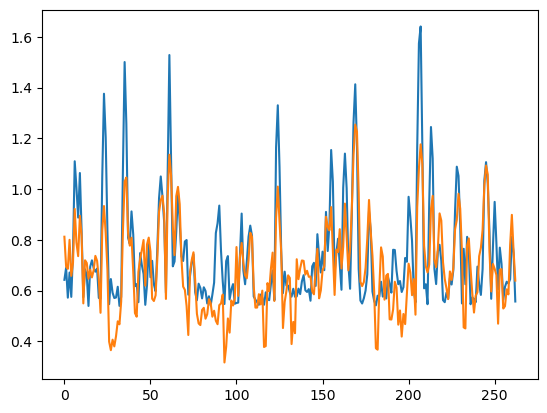

In [ ]:
plt.figure()
plt.plot(out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).values)
plt.plot(out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.98,dim='time'),drop=True).values)


In [17]:
out_ds.rmse_extremes.sel(split='test')

<xarray.DataArray 'rmse_extremes' (i: 1, quantile: 3)>
array([[0.13046875, 0.14627086, 0.17575544]])
Coordinates:
    split     <U5 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: i

In [18]:
out_ds.r_extremes.sel(split='test')

<xarray.DataArray 'r_extremes' (i: 1, quantile: 3)>
array([[0.76944061, 0.76073639, 0.72139865]])
Coordinates:
    split     <U5 'test'
  * quantile  (quantile) float64 0.95 0.98 0.99
Dimensions without coordinates: i

In [86]:
threshold_pct=99
threshold_value = ds.o.isel(i=0).isel(t=0).sel(split='test').quantile(.99,dim='time').values

y_true = ds.o.isel(i=0).isel(t=0).sel(split='test')#.dropna(dim='time')

surge_codec = xr.open_dataset('/home/jovyan/test_surge_models/CoDEC_ERA5_at_gesla3_tgs_eu_hourly_anoms.nc')
surge_codec = surge_codec.sel(tg='brest-822a-fra-uhslc.csv').sel(time=ds.time.where(np.isfinite(y_true),drop=True))
surge_codec['surge'] = surge_codec['surge'].rolling(time=3,min_periods=1,center=True).mean()
#surge_codec['surge'] = (surge_codec['surge'] - surge_codec['surge'].mean(dim='time'))/surge_codec['surge'].std(dim='time',ddof=0) #normalize
#surge_codec_test=surge_codec.surge.values[np.isfinite(y_true)]
#y_true = y_true[np.isfinite(y_true)]
y_true = y_true.values[np.isfinite(y_true)]
#surge_codec_test = surge_codec.sel(tg=tg).sel(time=predictand['date'].values[idx_test][n_steps-1::]).surge.values #select test timesteps
surge_codec_test_exceedances = (surge_codec.surge.values>=threshold_value).flatten() #find where exceeding threshold
y_true_exceedances = (y_true>=threshold_value)
print('---CoDEC---')
print('bulk correlation r='+str(np.corrcoef(surge_codec.surge.values,y_true)[0][1]))
print('bulk RMSE='+str(rmse(surge_codec.surge.values,y_true)))
print('Confusion matrix exceedances above {0}th percentile:'.format(threshold_pct))
print(confusion_matrix(y_true_exceedances,surge_codec_test_exceedances))

print('Correlation at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('r=' + str(np.corrcoef(surge_codec.surge.values[y_true_exceedances],y_true[y_true_exceedances])[0][1]))
print('RMSE at timesteps where observations above {0}th percentile:'.format(threshold_pct))
print('RMSE=' + str(rmse(surge_codec.surge.values[y_true_exceedances],y_true[y_true_exceedances])))


---CoDEC---
bulk correlation r=0.8749074081848153
bulk RMSE=0.06168423316154097
Confusion matrix exceedances above 99th percentile:
[[13115   120]
 [   23   111]]
Correlation at timesteps where observations above 99th percentile:
r=0.6438602402339738
RMSE at timesteps where observations above 99th percentile:
RMSE=0.07291014334262984


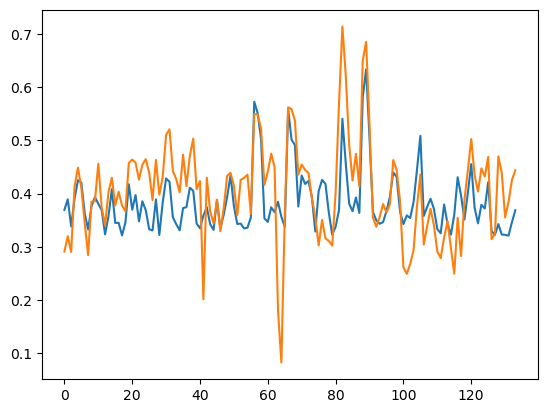

In [87]:

plt.plot(y_true[y_true_exceedances])
plt.plot(surge_codec.surge.values[y_true_exceedances])

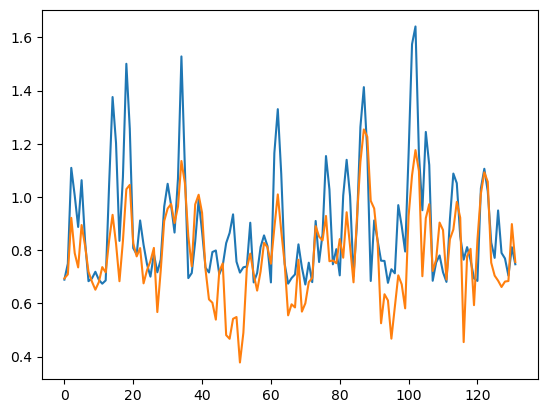

In [23]:
plt.plot(out_ds.o.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.99,dim='time'),drop=True).values)
plt.plot(out_ds.yhat.sel(split='test').isel(i=0).where(out_ds.o.sel(split='test').isel(i=0)>out_ds.o.sel(split='test').isel(i=0).quantile(.99,dim='time'),drop=True).values)


In [20]:
out_ds.r_bulk

<xarray.DataArray 'r_bulk' (i: 1, split: 3)>
array([[0.70603564, 0.67384388, 0.6716272 ]])
Coordinates:
  * split    (split) <U5 'train' 'val' 'test'
Dimensions without coordinates: i

In [21]:
out_ds.o.quantile(.99,dim='time')

<xarray.DataArray 'o' (i: 1, split: 3)>
array([[0.2005901 , 0.20513289, 0.20433226]])
Coordinates:
  * split     (split) <U5 'train' 'val' 'test'
    quantile  float64 0.99
Dimensions without coordinates: i

Tensorflow pipeline:

```python
#get values & timestamps of observations to compare predictions with
o_val = y_train_sd * y_val[np.isfinite(y_val)][0:int(np.sum(np.isfinite(y_val))/batch_size)] + y_train_mean #back-transform observations val split
o_test = y_train_sd * y_test[np.isfinite(y_test)][0:int(np.sum(np.isfinite(y_val))/batch_size)] + y_train_mean #back-transform observations val split

t_val = predictand['date'].values[idx_val][np.isfinite(y_val)][0:int(np.sum(np.isfinite(y_val))/batch_size)]
t_test = predictand['date'].values[idx_test][np.isfinite(y_test)][0:int(np.sum(np.isfinite(y_val))/batch_size)]

#create windowed predictors, filter out timesteps with NaN observations & create batches:
if use_dl == False: #if not using weights
    z_train = create_batched_sequenced_datasets(x_train, y_train, this_n_steps, this_batch_size).cache() #cache() speeds up the training by loading in the data at epoch 0, but takes up a lot of memory
    z_val = create_batched_sequenced_datasets(x_val, y_val, this_n_steps, this_batch_size).cache()

    x_val_ds = z_val.map(lambda a, b : a) #unpack z_val for prediction

elif use_dl == True: #if using weights
    z_train = create_batched_sequenced_datasets(x_train, y_train, this_n_steps, this_batch_size, w_train).cache()
    z_val = create_batched_sequenced_datasets(x_val, y_val, this_n_steps, this_batch_size, w_val).cache()

    x_val_ds = z_val.map(lambda a, b, c: a) #unpack z_val for prediction

z_test = create_batched_sequenced_datasets(x_test, y_test, this_n_steps, this_batch_size) #to-do: z_test doesn't have to be batched?
x_test_ds = z_test.map(lambda a, b: a) #unpack z_test for prediction

history = model.fit(z_train,epochs=n_epochs,validation_data=z_val,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                            restore_best_weights=True)],verbose=0) #train model
            
#make predictions & back-transform
yhat_val = model.predict(x_val_ds,verbose=0).flatten()*y_train_sd + y_train_mean
yhat_test = model.predict(x_test_ds,verbose=0).flatten()*y_train_sd + y_train_mean
```